# Perterbation Testing

To verify that my environment and morphology representation have continuous loss slope (and is therefore amenable to gradient descent),
I took existing pre-designed morphologies and randomly mutated one of the parameters (in this case, just one of the joint parameters).
The performance of the mutated morphology was compared to the original, and then the mutated parameter was permuted up and down by a small amount, and re-evaluated. 
The best performing permutation was kept and the other discarded. This permutation process was repeated 5 times in total, such that the permuted 'children' of 
the original mutated morphology were >= the first permutation's performance. The expectation was to see that bad mutations moved back towards the shape of the original.

This is a graph of how the mutated parameter changed over time.

In [88]:
import os
import re

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Import the Data

In [89]:
data_dir = "../models/permutation_testing"

df = pd.DataFrame(columns=["hand"] + [f"val_{i}" for i in range(6)] + [f"perf_{i}" for i in range(6)])

for idx, dir in enumerate(os.listdir(data_dir)):
    path = os.path.join(data_dir, dir)
    if not os.path.isdir(path) or ("task_7" not in dir) or ("hand_type_4" in dir):
        continue

    results = open(os.path.join(path, "results.txt"), "r")
    lines = results.readlines()
    results.close()

    # Find hand and task type
    hand_type = re.search(r"hand type: (\d+)", lines[0])[1]
    df.loc[idx, "hand"] = hand_type

    # Find parameter indices
    params = re.search(r"\[[\d,\s]+\]", lines[10])
    param_indices = re.findall(r"\d+", params.group(0))
    param_nums = [int(i) for i in param_indices]

    # Find parameter values
    original = re.findall(r"([-\d\.]+)", lines[10])[len(param_indices)]
    permuted = re.findall(r"([-\d\.]+)", lines[3])[int(param_indices[0])]
    vals = [re.findall(r"([-\d\.]+)", line)[2+len(param_indices)] for line in lines[5:9]]
    df.loc[idx, "val_0"] = original
    df.loc[idx, "val_1"] = permuted
    for i, val in enumerate(vals):
        df.loc[idx, f"val_{i + 2}"] = val

    # Find performance values
    original = re.findall(r"([-\d\.]+)", lines[2])[0]
    permuted = re.findall(r"([-\d\.]+)", lines[4])[0]
    vals = [re.findall(r"([-\d\.]+)", line)[1] for line in lines[5:9]]
    df.loc[idx, "perf_0"] = original
    df.loc[idx, "perf_1"] = permuted
    for i, val in enumerate(vals):
        df.loc[idx, f"perf_{i + 2}"] = val

In [95]:
# Convert cols to numbers
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col])

print(df)

   hand  val_0  val_1  val_2  val_3  val_4  val_5  perf_0  perf_1  perf_2  \
4     1    0.0   0.00   0.25   0.25   0.50   0.75     0.0   -2.75   -2.15   
7     5    0.0   0.00   0.12   0.25   0.37   0.50     0.0  -31.96  -21.55   
10    0    0.0  -0.75  -0.56  -0.37  -0.19  -0.19     0.0  -25.04  -16.84   
12    2    0.0   2.00   1.50   1.00   0.50   0.50     0.0   -8.11   -6.33   
14    3    0.0   2.00   1.50   1.00   0.50   0.50     0.0  -19.63  -12.99   

    perf_3  perf_4  perf_5  
4    -2.15    1.74    3.69  
7    -8.17   14.98   21.85  
10  -11.72   -7.02   -7.02  
12   -2.50    0.25    0.25  
14   -7.01   -2.93   -2.93  


## Graph the Values over Generations

In [91]:
# Normalize the performance and values
df.iloc[:, 1:7] = df.iloc[:, 1:7].apply(lambda x: x - x.iloc[0], axis=1)
df.iloc[:, 7:] = df.iloc[:, 7:].apply(lambda x: x - x.iloc[0], axis=1)
# val_std = df.iloc[:, 2:8].std(axis=1)
# perf_std = df.iloc[:, 8:].std(axis=1)
# df.iloc[:, 2:8] = df.iloc[:, 2:8].div(val_std, axis=0)
# df.iloc[:, 8:] = df.iloc[:, 8:].div(perf_std, axis=0)

# Melt the DataFrame for easier plotting
val_columns = [col for col in df.columns if col.startswith('val_')][1:] + ["hand"]
df_vals_long = df[val_columns].reset_index().melt(id_vars=['index', 'hand'], var_name='x', value_name='y')
df_vals_long['x'] = df_vals_long['x'].str.extract(r'val_(\d+)').astype(int)

perf_columns = [col for col in df.columns if col.startswith('perf_')][1:] + ["hand"]
df_perf_long = df[perf_columns].reset_index().melt(id_vars=['index', 'hand'], var_name='x', value_name='y')
df_perf_long['x'] = df_perf_long['x'].str.extract(r'perf_(\d+)').astype(int)

df_vals_long = df_vals_long.rename(columns={'index': 'line_id'})
df_perf_long = df_perf_long.rename(columns={'index': 'line_id'})

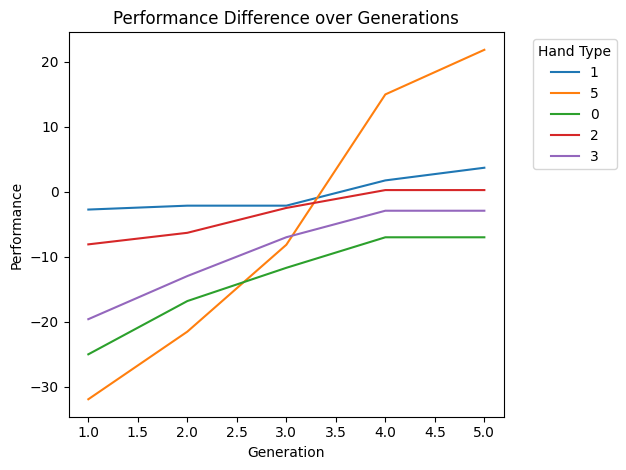

In [92]:
sns.lineplot(data=df_perf_long, x='x', y='y', hue='hand')
plt.xlabel("Generation")
plt.ylabel("Performance")
plt.title("Performance Difference over Generations")
plt.legend(title="Hand Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../diagrams/permutation_test_perf.png")
plt.show()

In [93]:
# Offset hand 2 for better visibility
df_vals_long.loc[df_vals_long['hand'] == '2', 'y'] += 0.02

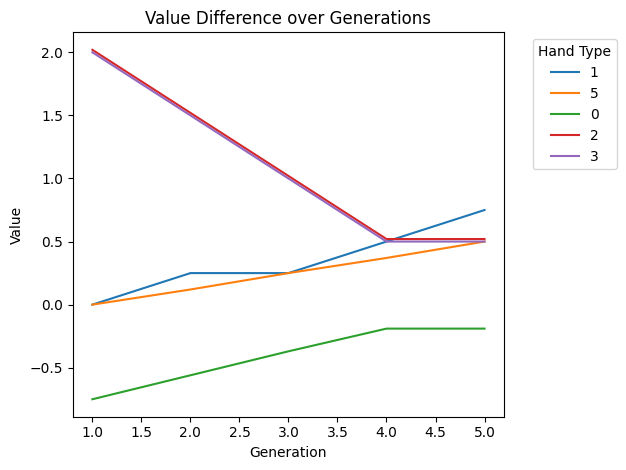

In [94]:
sns.lineplot(data=df_vals_long, x='x', y='y', hue='hand')
plt.xlabel("Generation")
plt.ylabel("Value")
plt.title("Value Difference over Generations")
plt.legend(title="Hand Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../diagrams/permutation_test_vals.png")
plt.show()